## Visualize The Policy Schedule of PBA



In [1]:
!pip install seaborn

import PIL
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cycler import cycler

import pba.augmentation_transforms_hp as augmentation_transforms_hp
from pba.utils import parse_log_schedule
from pba.data_utils import parse_policy

# Ignore the divided by zero warning in probability calculation
np.seterr(divide='ignore', invalid='ignore')

     |████████████████████████████████| 215kB 46kB/s eta 0:00:01


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# Initialize CIFAR & SVHN policies.
cifar_policy = (parse_log_schedule('schedules/rcifar10_16_wrn.txt', 200), 'cifar10_4000')
svhn_policy = (parse_log_schedule('schedules/rsvhn_16_wrn.txt', 160), 'svhn_1000')


W0929 12:05:13.592496 140674068162368 deprecation_wrapper.py:119] From /ss/Documents/github_repo/pba/pba/utils.py:88: The name tf.logging.debug is deprecated. Please use tf.compat.v1.logging.debug instead.

W0929 12:05:13.593467 140674068162368 deprecation_wrapper.py:119] From /ss/Documents/github_repo/pba/pba/utils.py:98: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



In [3]:
policy, dset = cifar_policy

# Initilize dictionaries
probability_results  = {'Rotate':[], 'TranslateX':[], 'TranslateY':[], 'Brightness':[], 
                        'Color':[], 'Invert':[] , 'Sharpness':[], 'Posterize':[], 
                        'ShearX':[], 'Solarize':[], 'ShearY':[], 'Equalize':[],
                        'AutoContrast':[], 'Cutout':[],'Contrast' :[]}
magnitude_results = copy.deepcopy(probability_results)
upper_probability  = copy.deepcopy(probability_results)
upper_magnitude = copy.deepcopy(probability_results)
bottom_probability = copy.deepcopy(probability_results)
bottom_magnitude= copy.deepcopy(probability_results)

def parse_policy_hyperparams(policy_hyperparams):
    """We have two sets of hparams for each operation, which we need to split up."""
    split = len(policy_hyperparams) // 2
    policy = parse_policy(policy_hyperparams[:split], augmentation_transforms_hp)
    policy.extend(parse_policy(policy_hyperparams[split:], augmentation_transforms_hp))
    return policy

def mean_hyperparams(policy):
    """Get mean value of two set of hparams in each operation, 
    both magnitude and probability."""
    for one_policy in policy:
        parsed_policy = parse_policy_hyperparams(one_policy)
        half_policy = len(parsed_policy) // 2
        for i in parsed_policy[:half_policy]:
            upper_magnitude[i[0]].append(i[1]) 
            upper_probability[i[0]].append(i[2])
        for i in parsed_policy[half_policy:]:
            bottom_magnitude[i[0]].append(i[1]) 
            bottom_probability[i[0]].append(i[2])

    for key, value in upper_probability.items():
        upper_array = np.array(upper_probability[key])
        bottom_array = np.array(bottom_probability[key])
        tmp_array = np.divide((upper_array+bottom_array),2)
        tmp_array = np.round(tmp_array, decimals=4).tolist()
        probability_results[key]=tmp_array

    for key, value in upper_magnitude.items():
        upper_array = np.array(upper_magnitude[key])
        bottom_array = np.array(bottom_magnitude[key])
        tmp_array = np.divide((upper_array+bottom_array),2)
        tmp_array = np.round(tmp_array, decimals=4).tolist()
        magnitude_results[key]=tmp_array
    return probability_results, magnitude_results

probability_results, magnitude_results = mean_hyperparams(policy)


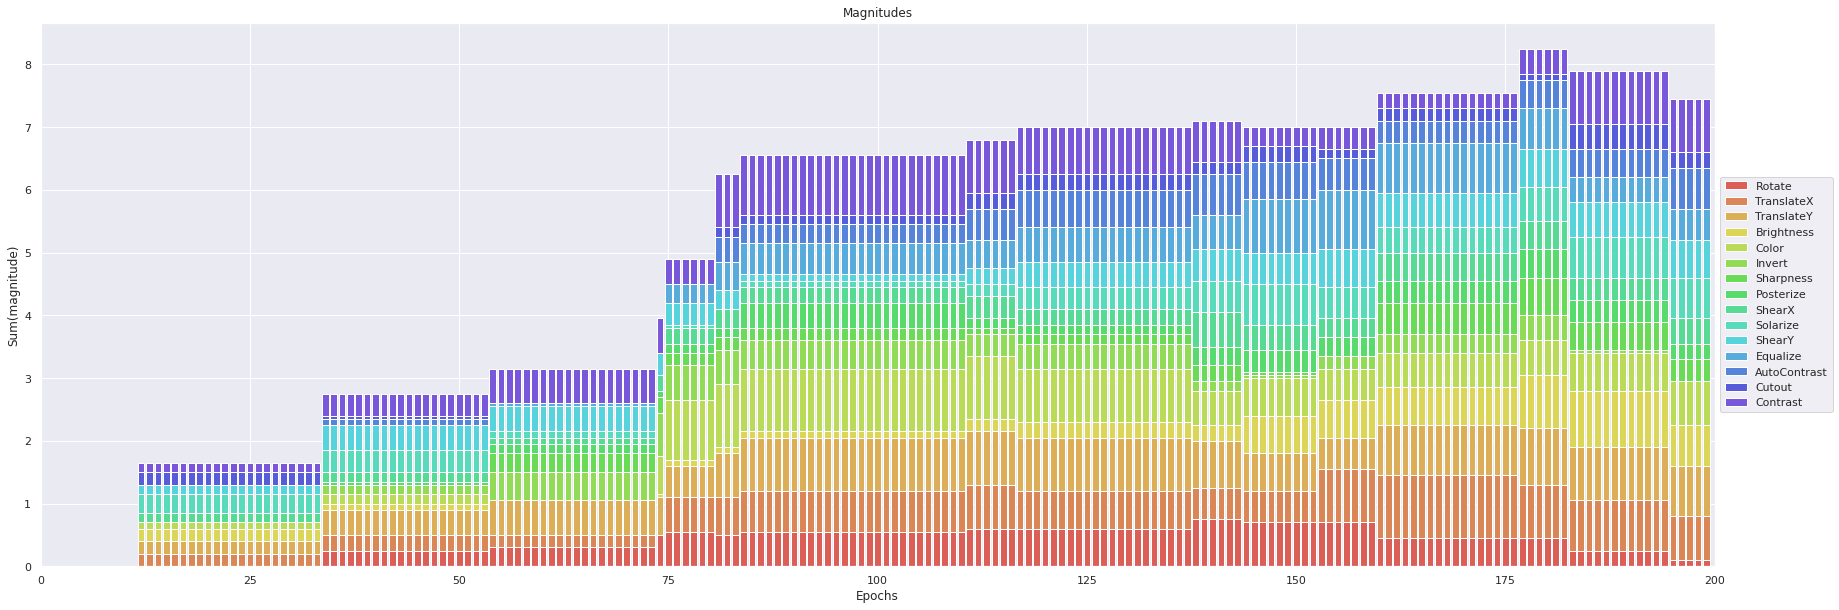

In [7]:
# Set unique color of every operation in the plot.
sns.set()
sns.set_palette(sns.color_palette("hls", 20))

ind_constant = len(magnitude_results["Rotate"])
ind = np.arange(ind_constant)

# Get sum of each operation magnitude at every epochs. 
# [sum of epoch1, sum of epoch2, sum of epoch3...]
def sum_results_array (index_to_sum, results_dict):
    sums = np.zeros(len(next(iter(results_dict.values()))))
    i = 0
    for value in results_dict.values():
        value = np.array(value)
        sums = sums+value
        if i==index_to_sum:
            break
        i=i+1
    return sums

# Plot each bar
plt.rcParams["figure.figsize"] = [30,10]
Rotate_bars = plt.bar(ind, magnitude_results["Rotate"])
TranslateX_bars = plt.bar(ind, magnitude_results["TranslateX"], 
                          bottom=sum_results_array(0,magnitude_results))
TranslateY_bars = plt.bar(ind, magnitude_results["TranslateY"], 
                          bottom=sum_results_array(1,magnitude_results))
Brightness_bars = plt.bar(ind, magnitude_results["Brightness"], 
                          bottom=sum_results_array(2,magnitude_results))
Color_bars = plt.bar(ind, magnitude_results["Color"], 
                     bottom=sum_results_array(3,magnitude_results))
Invert_bars = plt.bar(ind, magnitude_results["Invert"], 
                      bottom=sum_results_array(4,magnitude_results))
Sharpness_bars = plt.bar(ind, magnitude_results["Sharpness"], 
                         bottom=sum_results_array(5,magnitude_results))
Posterize_bars = plt.bar(ind, magnitude_results["Posterize"], 
                         bottom=sum_results_array(6,magnitude_results))
ShearX_bars = plt.bar(ind, magnitude_results["ShearX"], 
                      bottom=sum_results_array(7,magnitude_results))
Solarize_bars = plt.bar(ind, magnitude_results["Solarize"], 
                        bottom=sum_results_array(8,magnitude_results))
ShearY_bars = plt.bar(ind, magnitude_results["ShearY"], 
                      bottom=sum_results_array(9,magnitude_results))
Equalize_bars = plt.bar(ind, magnitude_results["Equalize"], 
                        bottom=sum_results_array(10,magnitude_results))
AutoContrast_bars = plt.bar(ind, magnitude_results["AutoContrast"], 
                            bottom=sum_results_array(11,magnitude_results))
Cutout_bars = plt.bar(ind, magnitude_results["Cutout"], 
                      bottom=sum_results_array(12,magnitude_results))
Contrast_bars = plt.bar(ind, magnitude_results["Contrast"], 
                        bottom=sum_results_array(13,magnitude_results))

plt.ylabel('Sum(magnitude)')
plt.xlabel('Epochs')
plt.title('Magnitudes')
plt.xlim([0, ind_constant])
bars_tag = ["Rotate","TranslateX","TranslateY","Brightness","Color","Invert",
            "Sharpness","Posterize","ShearX","Solarize","ShearY","Equalize",
            "AutoContrast","Cutout","Contrast"]
plt.legend(bars_tag, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("magnitude.png",bbox_inches='tight')
plt.show()

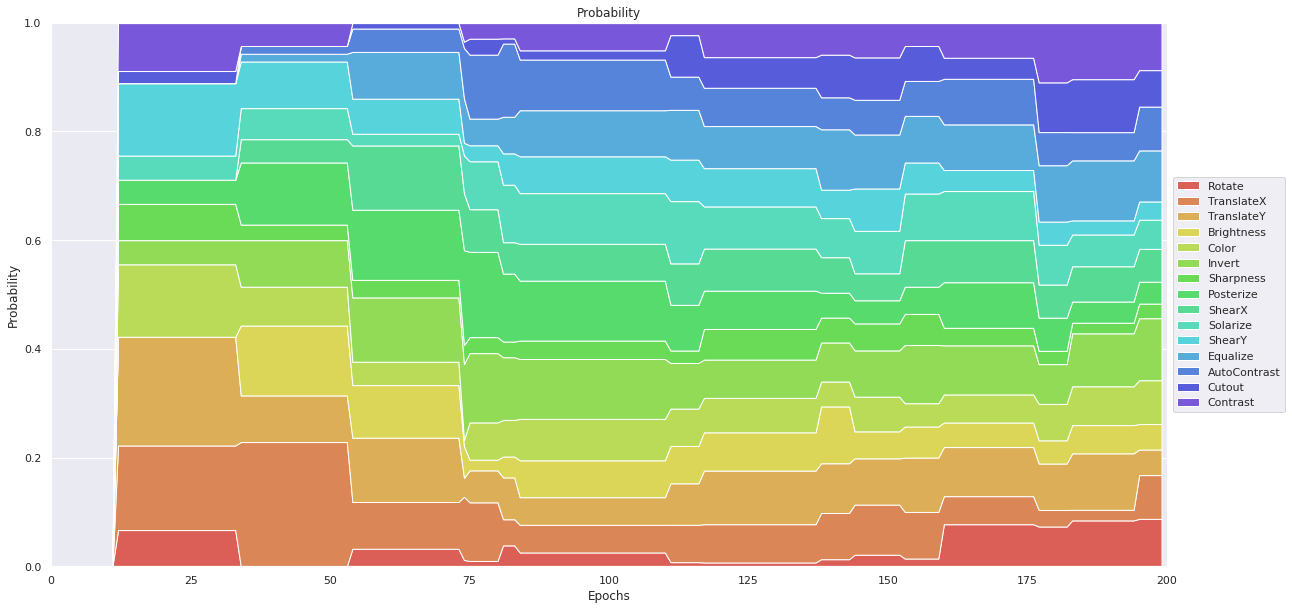

In [6]:
# Get total epochs 
epochs = len(next(iter(probability_results.values())))

# Sum of probability. 
#[sum of epoch1, sum of epoch2, sum of epoch3...]
sum_results = sum_results_array(epochs, probability_results)

# Get every operation's probability portion in that epoch
Rotate_1=np.nan_to_num(np.divide(probability_results["Rotate"], sum_results))
TranslateX_1 = np.nan_to_num(np.divide(probability_results["TranslateX"], sum_results))
TranslateY_1 = np.nan_to_num(np.divide(probability_results["TranslateY"], sum_results))
Brightness_1 = np.nan_to_num(np.divide(probability_results["Brightness"], sum_results))
Color_1 = np.nan_to_num(np.divide(probability_results["Color"], sum_results))
Invert_1 = np.nan_to_num(np.divide(probability_results["Invert"], sum_results))
Sharpness_1 = np.nan_to_num(np.divide(probability_results["Sharpness"], sum_results))
Posterize_1 = np.nan_to_num(np.divide(probability_results["Posterize"], sum_results))
ShearX_1 = np.nan_to_num(np.divide(probability_results["ShearX"], sum_results))
Solarize_1 = np.nan_to_num(np.divide(probability_results["Solarize"], sum_results))
ShearY_1 = np.nan_to_num(np.divide(probability_results["ShearY"], sum_results))
Equalize_1 = np.nan_to_num(np.divide(probability_results["Equalize"], sum_results))
AutoContrast_1 = np.nan_to_num(np.divide(probability_results["AutoContrast"], sum_results))
Cutout_1 = np.nan_to_num(np.divide(probability_results["Cutout"], sum_results))
Contrast_1 = np.nan_to_num(np.divide(probability_results["Contrast"], sum_results))

# Plot
plt.rcParams["figure.figsize"] = [20,10]
ind = np.arange(epochs)
plt.stackplot(ind, Rotate_1, TranslateX_1, TranslateY_1,Brightness_1,Color_1,
              Invert_1,Sharpness_1,Posterize_1,ShearX_1,Solarize_1,ShearY_1,
              Equalize_1,AutoContrast_1,Cutout_1,Contrast_1,labels=bars_tag)
plt.legend(bars_tag, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim([0, epochs])
plt.ylim([0, 1])
plt.ylabel('Probability')
plt.xlabel('Epochs')
plt.title('Probability')
plt.savefig("probability.png",bbox_inches='tight')
plt.show()